# 机器学习练习 5 - 偏差和方差

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()
X, y, Xval, yval, Xtest, ytest

(array([-15.93675813, -29.15297922,  36.18954863,  37.49218733,
        -48.05882945,  -8.94145794,  15.30779289, -34.70626581,
          1.38915437, -44.38375985,   7.01350208,  22.76274892]),
 array([ 2.13431051,  1.17325668, 34.35910918, 36.83795516,  2.80896507,
         2.12107248, 14.71026831,  2.61418439,  3.74017167,  3.73169131,
         7.62765885, 22.7524283 ]),
 array([-16.74653578, -14.57747075,  34.51575866, -47.01007574,
         36.97511905, -40.68611002,  -4.47201098,  26.53363489,
        -42.7976831 ,  25.37409938, -31.10955398,  27.31176864,
         -3.26386201,  -1.81827649, -40.7196624 , -50.01324365,
        -17.41177155,   3.5881937 ,   7.08548026,  46.28236902,
         14.61228909]),
 array([ 4.17020201e+00,  4.06726280e+00,  3.18730676e+01,  1.06236562e+01,
         3.18360213e+01,  4.95936972e+00,  4.45159880e+00,  2.22763185e+01,
        -4.38738274e-05,  2.05038016e+01,  3.85834476e+00,  1.93650529e+01,
         4.88376281e+00,  1.10971588e+01,  7.4617082

D:\Programmingtools\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


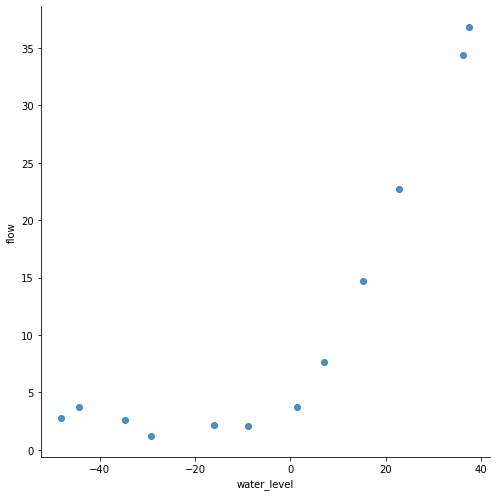

In [4]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot('water_level', 'flow', data=df, fit_reg=False, height=7)
plt.show()

In [5]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

# 代价函数
<img style="float: left;" src="linear_cost.png">

In [6]:
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [7]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

# 梯度
<img style="float: left;" src="linear_gradient.png">

In [8]:
def gradient(theta, X, y):
    m = X.shape[0]
    
    #J(θ)求导得 X *（h-y) 其中h=X @ theta
    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [9]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

# 正则化梯度
<img style="float: left;" src="linear_reg_gradient.png">

In [10]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [11]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

# 拟合数据
正则化项 λ=0

In [12]:
def linear_regression_np(X, y, l=1):
    theta = np.ones(X.shape[1])

    res  = opt.minimize(fun=regularized_cost,
                        x0=theta,
                        args=(X, y, l),
                        method='TNC',
                        jac=regularized_gradient,
                        options={'disp': True})
    return res

In [13]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2*m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [14]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')
final_theta

array([13.08790348,  0.36777923])

<function matplotlib.pyplot.show(close=None, block=None)>

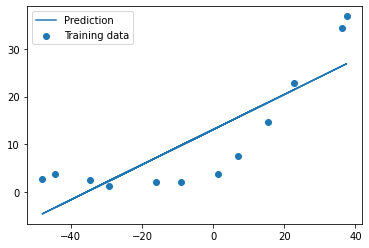

In [15]:
b = final_theta[0] #intercept
m = final_theta[1] #slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m +b, label="Prediction")
plt.legend(loc=2)
plt.show

In [16]:
training_cost, cv_cost = [], []

使用训练集的子集来拟合模型

在计算训练代价和交叉验证代价时，没有使用正则化

要用相同的训练集自己来计算训练代价

此处证明了训练集数据越多，验证集与训练集的拟合程度越接近

In [17]:
m = X.shape[0]
for i in range(1, m+1):
    print('i={}'.format(i))
    res = linear_regression_np(X[:i, :], y[:i], l=0)

    tc = regularized_cost(res.x, X[:i,:], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    print('tc={},cv={}'.format(tc,cv))
    training_cost.append(tc)
    cv_cost.append(cv)

i=1
tc=8.631534185484672e-18,cv=169.87070840820138
i=2
tc=1.1982973737990733e-17,cv=110.30036579345536
i=3
tc=3.286595045501271,cv=45.01023129175528
i=4
tc=2.8426776893997996,cv=48.368911427598995
i=5
tc=13.154048809114986,cv=35.865163780539554
i=6
tc=19.443962512495503,cv=33.82996187443447
i=7
tc=20.098521655088923,cv=31.970985697553704
i=8
tc=18.17285869520003,cv=30.862446276219675
i=9
tc=22.609405424954723,cv=31.13599798073065
i=10
tc=23.261461592611823,cv=28.936207557816495
i=11
tc=24.31724958804432,cv=29.55143239179086
i=12
tc=22.373906495108912,cv=29.433818153684726


<function matplotlib.pyplot.show(close=None, block=None)>

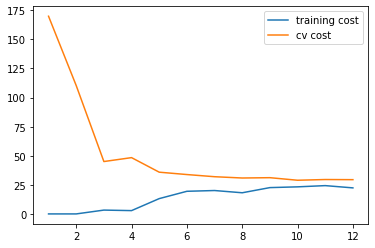

In [18]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show

模型拟合不太好，欠拟合了

# 创建多项式特征
1. 扩展特征到 8阶,或者你需要的阶数
2. 使用 **归一化** 来合并 $x^n$ 
3. don't forget intercept term

In [19]:
def normalize_feature(df):
    """applies function along input axis(default 0) of DataFram."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

    

In [20]:
def prepare_poly_data(*args, power):
    """
    args:keep feeding in X, Xval, or Xtest
       will return in the same  order
    """
    def prepare(x):
        #expand feature
        df = poly_features(x, power= power)

        #normalization
        ndarr = normalize_feature(df).values #原来是as_matrix() 表格转化为矩阵

        #add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [21]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.values if as_ndarray else df  #返回格式为数组或者表格

In [22]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [23]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 准备多项式回归数据


In [24]:
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power=8)
X_polydf=pd.DataFrame(X_poly)
X_polydf
#X_poly[:3, :]

,0,1,2,3,4,5,6,7,8
0,1.0,-0.362141,-0.755087,0.182226,-0.706190,0.306618,-0.590878,0.344516,-0.508481
1,1.0,-0.803205,0.001258,-0.247937,-0.327023,0.093396,-0.435818,0.255416,-0.448912
2,1.0,1.377467,0.584827,1.249769,0.245312,0.978360,-0.012156,0.756568,-0.170352
3,1.0,1.420940,0.706647,1.359846,0.395534,1.106162,0.125637,0.871929,-0.059638
4,1.0,-1.434149,1.854000,-2.037163,2.331431,-2.411536,2.602212,-2.645675,2.766085
5,1.0,-0.128687,-0.975969,0.251385,-0.739687,0.316953,-0.594997,0.345812,-0.508955
6,1.0,0.680582,-0.780029,0.340656,-0.711721,0.326509,-0.591790,0.346830,-0.508613
7,1.0,-0.988534,0.451358,-0.601282,0.092917,-0.218473,-0.141608,0.039403,-0.266693
8,1.0,0.216076,-1.074993,0.266275,-0.743369,0.317561,-0.595129,0.345835,-0.508960
9,1.0,-1.311501,1.422806,-1.548121,1.493396,-1.515908,1.388655,-1.368307,1.224144


# 画出学习曲线

首先，不适用正则化，所以λ=0

In [25]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m+1):
        #使用优化函数来获得每轮的最优θ值
        res = linear_regression_np(X[:i, :], y[:i], l=l)
        
        #这里计算的损失是未正则化的损失（因为前面正则化模型欠拟合，所以减小λ来解决高偏差/欠拟合的问题），正则化只用于优化θ
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m+1), training_cost, label='training cost')
    plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
    plt.legend(loc=1)

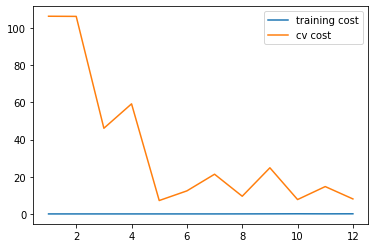

In [26]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

训练代价过低，过拟合了

# try $\lambda=1$

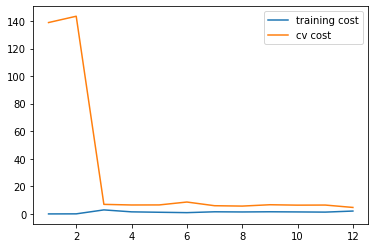

In [27]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

训练代价增加了些，不再是0了。减轻了过拟合。

# try $\lambda=100$

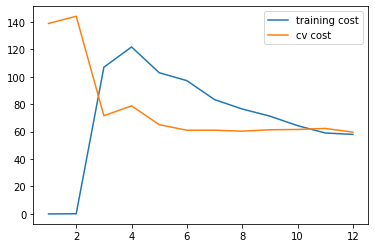

In [28]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

太多正则化了

再次变成**欠拟合**状态

# 找到最佳的 $\lambda$

In [29]:
l_candidate = [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28 , 2.56, 5.12, 10]
training_cost , cv_cost = [], []


In [30]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y , l)

    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)

    training_cost.append(tc)
    cv_cost.append(cv)
    

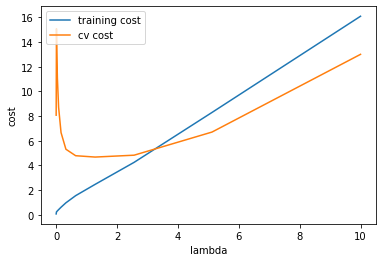

In [31]:
plt.plot(l_candidate, training_cost, label='training cost')
plt.plot(l_candidate, cv_cost, label='cv cost')
plt.legend(loc= 2)

plt.xlabel('lambda')
plt.ylabel('cost')

plt.show()

In [32]:
#从交叉验证集中获得最优的参数模型
l_candidate[np.argmin(cv_cost)]

1.28

In [36]:
#使用测试集数据来计算损失
for l  in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.4009230979044
test cost(l=0.01) = 10.881075147337429
test cost(l=0.02) = 10.387759259299374
test cost(l=0.04) = 9.729269413032492
test cost(l=0.08) = 8.917668274538663
test cost(l=0.16) = 8.02523501871352
test cost(l=0.32) = 7.283799849466189
test cost(l=0.64) = 7.0866877522142815
test cost(l=1.28) = 7.920138036881856
test cost(l=2.56) = 10.614074307844067
test cost(l=5.12) = 16.774418900643532
test cost(l=10) = 27.7150803078716


调参后， λ = 0.64 是最优选择， 这个时候测试代价最小